In [ ]:
# load libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jnjco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
## Select  specific legislatures to identify instances of parliamentary debates on Brexit

df_54 = pd.read_csv("./output_54.csv")
df_55 = pd.read_csv("./output_55.csv")
df_56 = pd.read_csv("./output_56.csv")
df_57 = pd.read_csv("./output_57.csv")
df_58 = pd.read_csv("./output_58.csv")

In [ ]:
df = pd.concat([df_54, df_55,
               df_56, df_57, df_58], ignore_index=True)

In [ ]:
# Simple dictionary to identify Brexit-related speeches
df['contains_brexit'] = df['text'].str.contains(r'\bBrexit\b', case=False, na=False)

In [10]:
df["contains_brexit"].value_counts()

contains_brexit
False    2976031
True       17546
Name: count, dtype: int64

In [11]:
df = df[df["date"] >= "2010-01-01"]

In [13]:
df['month_year'] = df['date'].dt.to_period('M')

In [ ]:
# Calculate the share of Brexit-related speeches by party and month

share_brexit = (
    df
    .groupby(['party', 'month_year'])['contains_brexit']
    .mean()
    .reset_index(name='share_contains_brexit')
)

In [39]:
share_brexit['month_year'] = share_brexit['month_year'].dt.to_timestamp()


In [47]:
parties_to_keep = [
    'Conservative Party',
    'Labour Party',
    'Liberal Democrats'
]

share_brexit = share_brexit[share_brexit['party'].isin(parties_to_keep)]

In [48]:
share_brexit = share_brexit[share_brexit['month_year'] >= '2016-01']

In [ ]:
custom_palette = {
    'Conservative Party': 'blue',
    'Labour Party': 'red',
    'Liberal Democrats': 'orange'
}

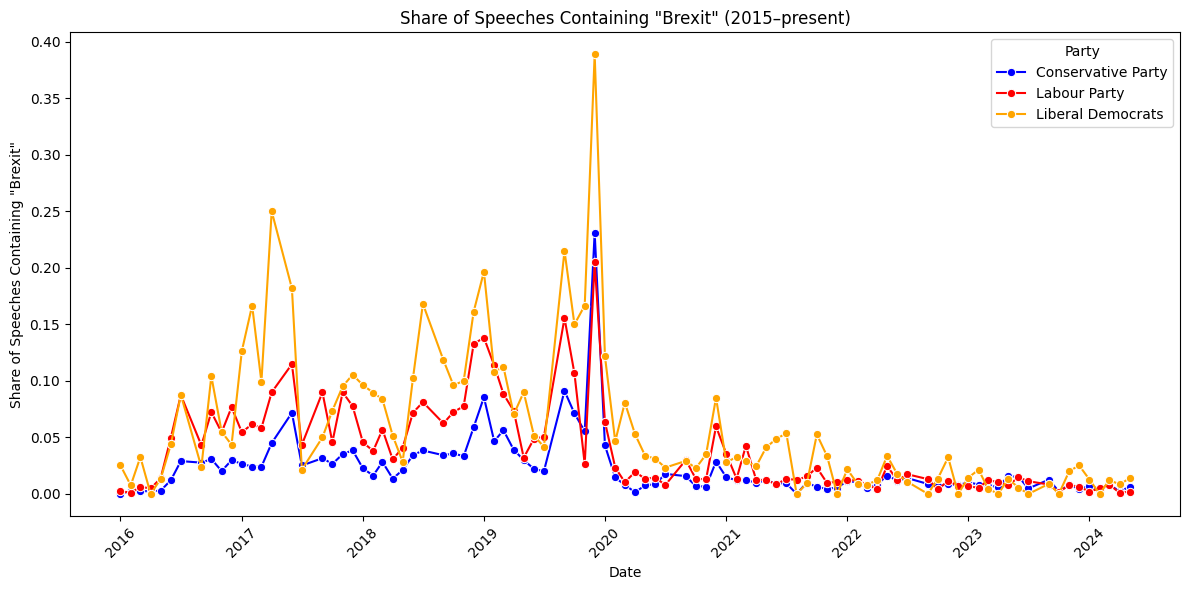

In [ ]:
## Recreate Figure X


plt.figure(figsize=(12, 6))
sns.lineplot(
    data=share_brexit,
    x='month_year',
    y='share_contains_brexit',
    hue='party',
    palette=custom_palette,
    marker='o'
)

# Aesthetics
plt.title('Share of Speeches Containing "Brexit" (2016–present)')
plt.xlabel('Date')
plt.ylabel('Share of Speeches Containing "Brexit"')
plt.xticks(rotation=45)
plt.legend(title='Party')
plt.tight_layout()
plt.show()

After having conducted this first descriptive analysis, we now only select the sentences that contain the word "Brexit" to conduct the NLP analysis.

In [15]:
df_brexit = df[df["contains_brexit"] == True]

In [ ]:
df_brexit['sentences'] = df_brexit['text'].apply(sent_tokenize)

C:\Users\jnjco\AppData\Local\Temp\ipykernel_18216\226320002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_brexit['sentences'] = df_brexit['text'].apply(sent_tokenize)


In [ ]:
df_exploded = df_brexit.explode('sentences').reset_index(drop=True)

In [18]:
df_exploded['contains_brexit_2'] = df_exploded['sentences'].str.contains(r'\bBrexit\b', case=False, na=False)

In [19]:
df_exploded['contains_brexit_2'].value_counts()

contains_brexit_2
False    239389
True      26475
Name: count, dtype: int64

In [20]:
df_brexit_sent = df_exploded[df_exploded["contains_brexit_2"] == True]

In [21]:
df_partisan = df[['party','month_year','constituency']]

In [22]:
df2 = df.groupby(['constituency','month_year', 'contains_brexit']).size().reset_index(name='count')

In [25]:
pivot_df = df2.pivot_table(index=['constituency', 'month_year'],
                          columns='contains_brexit',
                          values='count',
                          fill_value=0)

In [26]:
pivot_df.head()

contains_brexit          False  True 
constituency month_year              
Aberavon     2010-02       2.0    0.0
             2010-03       1.0    0.0
             2010-11       3.0    0.0
             2010-12       1.0    0.0
             2011-02       1.0    0.0

In [27]:
pivot_df.columns = ['count_false', 'count_true']

# Calculate share of True
pivot_df['share_true'] = pivot_df['count_true'] / (pivot_df['count_true'] + pivot_df['count_false'])

# Reset index if you want a flat DataFrame
result_df = pivot_df.reset_index()

In [28]:
result_df.head(100)

,constituency,month_year,count_false,count_true,share_true
0,Aberavon,2010-02,2.0,0.0,0.0
1,Aberavon,2010-03,1.0,0.0,0.0
2,Aberavon,2010-11,3.0,0.0,0.0
3,Aberavon,2010-12,1.0,0.0,0.0
4,Aberavon,2011-02,1.0,0.0,0.0
...,...,...,...,...,...
95,Aberavon,2022-10,3.0,0.0,0.0
96,Aberavon,2022-11,10.0,0.0,0.0
97,Aberavon,2022-12,3.0,0.0,0.0
98,Aberavon,2023-01,21.0,0.0,0.0


In [ ]:
# dataframe with party, month_year, constituency and information about Brexit salience

results_df = pd.merge(result_df, df_partisan, on=['constituency', 'month_year'], how='left')

In [32]:
results_df.drop_duplicates(subset=['constituency', 'month_year'], keep='first', inplace=True)

In [ ]:
# data of share of claimants as a share of the working age population
df_claimants = pd.read_csv("./ONS_claimants_data.csv")

In [ ]:
# Reshape the DataFrame to long format
df_long = pd.melt(
    df_claimants,
    id_vars=["Constituency"],      
    var_name="Date",              
    value_name="Value"             
)


In [ ]:
# Convert the 'Date' column to a datetime format
df_long['month_year'] = pd.to_datetime(
    df_long['Date'].apply(lambda x: f'01-{x}'), 
    format='%d-%y-%b'
).dt.to_period('M')

In [ ]:
# Merge the results_df with df_long on constituency and month_year to incorporate claimant data

df_merge = pd.merge(
    results_df,
    df_long,
    left_on=['constituency', 'month_year'],
    right_on=['Constituency', 'month_year'],
    how='right'
)

In [26]:
df_merge = df_merge[df_merge["share_true"] > 0]

In [ ]:
# export output to csv, which can be used for further analysis in R

df_merge.to_csv("./commons_corpus_brexit.csv")